In [1]:
# Chargement du script raster_tools (un module - et pour l'instant l'unique - du package telenvi)
from telenvi import raster_tools as rt

In [2]:
# Définition des chemins vers les cibles d'intérêt pour nos tests
path_im_sentinel = "/hello/CAM-RANH_2022_06_21_S2A/T49PBP_20220621T030551_B04.jp2"
path_im_landsat = "/hello/CAM-RANH_2011_10_30_LS8/LT05_L2SP_123052_20111030_20200820_02_T1_SR_B4.TIF"

In [3]:
"""
La fonction principale associée à la classe GeoIm est openGeoRaster. Elle permet de créer
un GeoIm directement à partir d'un fichier raster. 

Une partie des traitements applicables aux GeoIms le sont directement lors de l'ouverture
des rasters, grâce à des paramètres facultatifs de cette fonction openGeoRaster. 

Voyons comment s'en servir et ce que l'on peut en tirer.
"""
pass

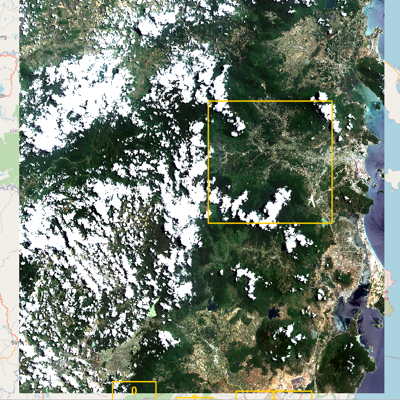

In [4]:
"""
1 - Ouverture et crop
Le crop d'un raster dès son ouverture a un intérêt principal : réduire drastiquement le temps d'ouverture.

La figure ci-dessous permet de visualiser l'emprise sur laquelle on va venir découper l'image (en jaune)
"""
from PIL import Image
Image.open("/hello/CAM-RANH_2022_06_21_S2A/zone_crop_sentinel.png").resize((400, 400))

In [5]:
# Ouverture sans crop - 6 secondes d'ouverture
full_im_sentinel = rt.openGeoRaster(path_im_sentinel)

uint16
Read as array from GeoIm.__init__ function

geoim from file T49PBP_20220621T030551_B04.jp2 ready



In [6]:
# Ouverture avec crop - Moins de 2 secondes d'ouvertures
crop_im_sentinel = rt.openGeoRaster(
    rasterPath = path_im_sentinel,
    crop = "/hello/CAM-RANH_2011_10_30_LS8/zones_interet.shp",
    pol =3)

uint16
Read as array from GeoIm.__init__ function

geoim from file T49PBP_20220621T030551_B04.jp2 ready



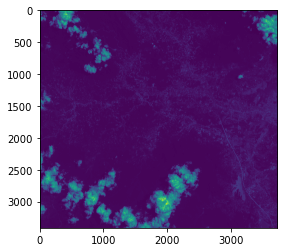

In [7]:
crop_im_sentinel.quickVisual()



resample
---
in     : 10.0
out    : 1000
method : average
---

crop
---
xMin : 256810.1849420591
yMin : 1337746.088816347
xMax : 294116.5917505601
yMax : 1371880.6958557044
---

uint16
Read as array from GeoIm.__init__ function

geoim from file T49PBP_20220621T030551_B04.jp2 ready



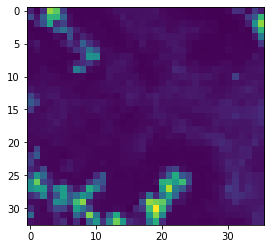

In [8]:
"""
2 - Ouverture et rééchantillonage
Il est possible d'ouvrir une image en réduisant directement sa résolution.
Pareil, gros gain de temps d'exécution sur l'ouverture.
"""
res_im_sentinel = rt.openGeoRaster(
    rasterPath = path_im_sentinel,
    crop = "/hello/CAM-RANH_2011_10_30_LS8/zones_interet.shp",
    pol = 3,
    res = 1000,
    resMethod = "average",
    verbose = True
)

res_im_sentinel.quickVisual()

In [9]:
"""
3 - Ouverture et reprojection
Il est possible d'ouvrir une image en modifiant son système de projection.
"""
reproj_im_sentinel = rt.openGeoRaster(
    rasterPath = path_im_sentinel,
    verbose=True,
    epsg = 4326
)

reproj_im_sentinel



reprojection
---
in  : 32649
out : 4326
---

uint16
Read as array from GeoIm.__init__ function

geoim from file T49PBP_20220621T030551_B04.jp2 ready

pixel size : (9.11214546821619e-05, -9.11214546821619e-05)
origin     : (108.23813543783288, 12.658786472288012)
bands      : 1
rows       : 10978
columns    : 11159
SCR epsg   : 4326
SCR name   : WGS 84
array type : uint16
driver enc : 2



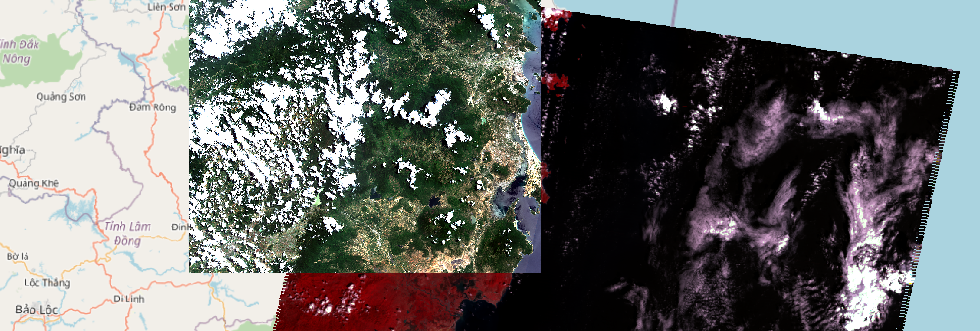

In [10]:
"""
4 - Tout-en-un : clip
L'argument 'clip' permet de récupérer les données de l'image source, et de les formater selon une image modèle. 
Par formater, on entend découper sur la zone de chevauchement, adapter la résolution à celle de l'image modèle,
reprojeter dans le même système de projection et décaler l'origine du raster.

Dans l'exemple ci-dessous, on va travailler à partir d'une image landsat 4 de 2011 et une image sentinel 2 de 2022 acquise au dessus de la côte Est Vietnamienne, proche de la ville de Cam-Ranh. 
Les deux images se chevauchent en partie. Les pixels sentinel font 10m, et les landsat 30m.
"""

from PIL import Image
Image.open("/hello/CAM-RANH_2011_10_30_LS8/chevauchement.png")



crop
---
xMin : 206985.0
yMin : 1290240.0
xMax : 309780.0
yMax : 1383615.0
---

uint16
Read as array from GeoIm.__init__ function

geoim from file T49PBP_20220621T030551_B04.jp2 ready



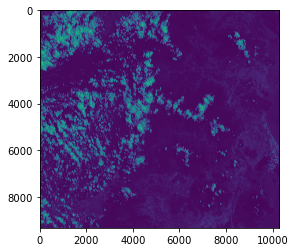

In [11]:
# 1 - Ouverture de l'image sentinel en la clippant sur l'image Landsat
im_sentinel = rt.openGeoRaster(
    rasterPath = path_im_sentinel,
    verbose = True,
    clip = path_im_landsat)

im_sentinel.quickVisual()



resample
---
in     : 30.0
out    : 9.999513618677042
method : near
---

crop
---
xMin : 206985.0
yMin : 1290240.0
xMax : 309780.0
yMax : 1383615.0
---

uint16
Read as array from GeoIm.__init__ function

geoim from file LT05_L2SP_123052_20111030_20200820_02_T1_SR_B4.TIF ready

pixel size : (9.999513618677042, -9.999464553437567)
origin     : (206985.0, 1383615.0)
bands      : 1
rows       : 9338
columns    : 10280
SCR epsg   : 32649
SCR name   : WGS 84 / UTM zone 49N
array type : uint16
driver enc : 2




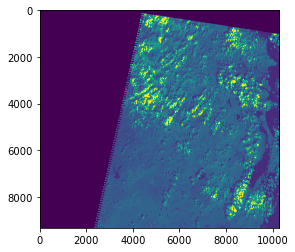

In [12]:
# 2 - Ouverture de l'image landsat en la croppant sur le geiom précédent, pour que le formatage soit identique dans les deux sens
im_landsat = rt.openGeoRaster(
    rasterPath=path_im_landsat,
    verbose=True,
    clip = im_sentinel)

print(im_landsat)
im_landsat.quickVisual()

In [13]:
# L'image landsat initiale a des bords noirs en nodata, et c'est pour ça qu'on les récupère sur l'intersection des deux images. 
# En tout cas, nos deux geoim ont bien la même taille de pixels, la même origine, et le même nombre de lignes / colonnes. 
# Prêt pour y appliquer des masques identiques, faire des calculs statistiques...